In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## mount error 나는 경우 
#!fusermount -u gdrive
#!google-drive-ocamlfuse gdrive

In [3]:
!ls

gdrive	sample_data


In [0]:
import os
os.chdir("gdrive/My Drive/big_project")

In [0]:
# 한번 만 실행하기 
#!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [6]:
# Enable this for some more verbose info.
debugging = True
#import tensorflow as tf
from keras import backend as K
K.clear_session()

Using TensorFlow backend.
W0824 20:04:01.660760 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0824 20:04:01.661868 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0824 20:04:01.703082 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [7]:
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard

     |████████████████████████████████| 88.8MB 1.2MB/s 
     |████████████████████████████████| 71kB 31.3MB/s 
     |████████████████████████████████| 3.8MB 42.0MB/s 
     |████████████████████████████████| 450kB 50.7MB/s 


#Common imports

In [8]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import collections

# Root directory of the project
ROOT_DIR = os.path.abspath("./")
ROOT_IMAGE_DIR = os.path.abspath("../images/")

# Path to the dataset (note this is a shared images directory)
dataset_path = os.path.join(ROOT_IMAGE_DIR, "")

models_dir = os.path.join(ROOT_DIR, "models/")

print("base dataset dir:", dataset_path)
print("base modesl dir:", models_dir)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(models_dir, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

print("init_weights dir: ", COCO_WEIGHTS_PATH)

base dataset dir: /content/gdrive/My Drive/big_project/images/
base modesl dir: /content/gdrive/My Drive/big_project/Mask_RCNN/models/
init_weights dir:  /content/gdrive/My Drive/big_project/Mask_RCNN/models/mask_rcnn_coco.h5


In [0]:
# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline

In [0]:
# For Config and Dataset 
sys.path.append(os.path.join(ROOT_DIR, ""))  # To find local version
import det as det

In [0]:
#%%time

# For debugging...
#if debugging:
#    # Load annotations
#    print(dataset_path)
#    annotations = json.load(open(os.path.join(dataset_path, "cigarette_images/annotations.json")))
#    annotations = list(annotations.values())  # don't need the dict keys

    # The VIA tool saves images in the JSON even if they don't have any
    # annotations. Skip unannotated images.
#    annotations = [a for a in annotations if a['regions']]

#    for a in annotations:
#        print(a['filename'])

#Load dataset

In [0]:
#len(annotations)

In [0]:
# mistake check
#for a in annotations:
#  for id, region in a['regions'].items():
#    t = region['region_attributes']
#    s = region['shape_attributes']['name']
#    if bool(t.values()) == False or s != 'polygon':
#      print(t, a['filename'])
#      print(s, a['filename'])

In [0]:
#config = det.DetConfig('cigarette', ['cigarette'])

In [0]:
#%%time
# Load dataset
#dataset, _ = det.create_datasets(dataset_path+"/cigarette_images",  config)

# Must call before using the dataset, amount other things,
# this maps the sources to the class ids.
#dataset.prepare()

# Print a summary of the dataset and classes
#print("Image Count: {}".format(len(dataset.image_ids)))
#print("Class Count: {}".format(dataset.num_classes))
#for i, info in enumerate(dataset.class_info):
#    print("{:3}. {:50}".format(i, info['name']))

#Augmentation

In [0]:
# The imgaug library is pretty flexible and make different types of augmentation possible. 
# The deterministic setting is used because any spatial changes to the image must also be 
# done to the mask. There are also some augmentors that are unsafe to apply. From the mrcnn
# library: 
# Augmentors that are safe to apply to masks: 
# ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", 
# "Flipud", "CropAndPad", "Affine", "PiecewiseAffine"]
# Affine, has settings that are unsafe, so always
# test your augmentation on masks

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sequential
seq_of_aug = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # horizontally flip 50% of the images
    iaa.Fliplr(0.5), 

    # Gaussian blur to 50% of the images
    # with random sigma between 0 and 0.5.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them from 90% 5o 110%
    # Translate/move them, rotate them
    # Shear them slightly -2 to 2 degrees.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order

#TRAIN

In [17]:
print("dataset dir:", dataset_path)
print("modesl dir:", models_dir)

dataset dir: /content/gdrive/My Drive/big_project/images/
modesl dir: /content/gdrive/My Drive/big_project/Mask_RCNN/models/


In [18]:
# Setup configuration
config = det.DetConfig('cigarette', ['cigarette'])
config.display()


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'cigarette']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['cigarette']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss':

In [19]:
config.ACTIVATION = 'leakyrelu'
config.DETECTION_MIN_CONFIDENCE = 0.9
print(config.ACTIVATION)
print(config.DETECTION_MIN_CONFIDENCE)

leakyrelu
0.9


In [20]:
# Create the model
model = modellib.MaskRCNN(mode='training', 
                          config=config,
                          model_dir=models_dir)

model.keras_model.summary()

W0824 20:04:51.983084 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 20:04:52.038715 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 20:04:52.072482 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0824 20:04:52.076361 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0824 20:04:54.475646 140019266729856 deprecation

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
# Load the weights

# Local path to trained weights file
## COCO_MODEL_PATH = os.path.join(models_dir, "alcohol20190814T1558/mask_rcnn_alcohol_0003.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
else:
    print("using existing ", COCO_WEIGHTS_PATH)
    
# For the coco dataset exclude the last layers because 
# it requires a matching number of classes
print("loading...", end='')
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

print("loaded.")

using existing  /content/gdrive/My Drive/big_project/Mask_RCNN/models/mask_rcnn_coco.h5
loading...loaded.


In [0]:
import tensorflow as tf
import datetime, os

def train(model, dataset_path, epochs=10):
    """Train the model."""
    use_multiprocessing=True
    
    # Create the train and val dataset.
    dataset_train, dataset_val = det.create_datasets(dataset_path+'/cigarette_images', config)

    # Prepare them
    dataset_train.prepare()
    dataset_val.prepare()
    
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    # Experiment with training options.
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    history = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='all',
                augmentation=seq_of_aug
                )
    
    return history

In [23]:
%%time
history = train(model, dataset_path, 2)

Counter({'cigarette': 762})
Counter({'cigarette': 200})
Adding class   1:cigarette
Adding class   1:cigarette
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/big_project/Mask_RCNN/models/cigarette20190824T2005/mask_rcnn_cigarette_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_bran

W0824 20:09:55.545308 140019266729856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/5
100/100 [==============================] - 312s 3s/step - loss: 2.0289 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.6114 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.7169 - mrcnn_mask_loss: 0.5970 - val_loss: 1.4704 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.4607 - val_mrcnn_class_loss: 0.0727 - val_mrcnn_bbox_loss: 0.5450 - val_mrcnn_mask_loss: 0.3831

Epoch 00001: saving model to /content/gdrive/My Drive/big_project/Mask_RCNN/models/cigarette20190824T2005/mask_rcnn_cigarette_0001.h5
Epoch 2/5
100/100 [==============================] - 192s 2s/step - loss: 1.3045 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4628 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.4321 - mrcnn_mask_loss: 0.3541 - val_loss: 0.9793 - val_rpn_class_loss: 0.0081 - val_rpn_bbox_loss: 0.2677 - val_mrcnn_class_loss: 0.0509 - val_mrcnn_bbox_loss: 0.3494 - val_mrcnn_mask_loss: 0.3032

Epoch 00002: saving model to /content/gdrive/My Drive/big_project/Mask_RCNN/models/cigarette20190824T2005/mask_r

E0824 20:20:50.940581 140013880731392 model.py:1812] Error processing image {'id': 'cigarette_0242.jpg', 'source': 'cigarette', 'path': '/content/gdrive/My Drive/big_project/images//cigarette_images/cigarette_0242.jpg', 'width': 1200, 'height': 628, 'polygons': [{'name': 'polygon', 'all_points_x': [759, 690, 677, 704, 552, 516, 527, 705, 683, 714, 915, 1033, 931, 843, 834, 1127, 1194, 1194, 1037, 1008, 759], 'all_points_y': [264, 281, 335, 370, 404, 427, 466, 432, 474, 518, 508, 526, 545, 583, 629, 623, 626, 214, 220, 245, 264]}], 'r_object_name': ['cigarette']}
Traceback (most recent call last):
  File "/content/gdrive/My Drive/big_project/Mask_RCNN/mrcnn/model.py", line 1711, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/gdrive/My Drive/big_project/Mask_RCNN/mrcnn/model.py", line 1214, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/content/gdrive/My Drive/big_project/Mask_RCNN/det.py", line 210, in load_mask
    mask[rr, cc, i

 38/100 [==========>...................] - ETA: 1:37 - loss: 1.0032 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2482 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.3504{'id': 'cigarette_0242.jpg', 'source': 'cigarette', 'path': '/content/gdrive/My Drive/big_project/images//cigarette_images/cigarette_0242.jpg', 'width': 1200, 'height': 628, 'polygons': [{'name': 'polygon', 'all_points_x': [759, 690, 677, 704, 552, 516, 527, 705, 683, 714, 915, 1033, 931, 843, 834, 1127, 1194, 1194, 1037, 1008, 759], 'all_points_y': [264, 281, 335, 370, 404, 427, 466, 432, 474, 518, 508, 526, 545, 583, 629, 623, 626, 214, 220, 245, 264]}], 'r_object_name': ['cigarette']}


E0824 20:21:05.083743 140013880731392 model.py:1812] Error processing image {'id': 'cigarette_0242.jpg', 'source': 'cigarette', 'path': '/content/gdrive/My Drive/big_project/images//cigarette_images/cigarette_0242.jpg', 'width': 1200, 'height': 628, 'polygons': [{'name': 'polygon', 'all_points_x': [759, 690, 677, 704, 552, 516, 527, 705, 683, 714, 915, 1033, 931, 843, 834, 1127, 1194, 1194, 1037, 1008, 759], 'all_points_y': [264, 281, 335, 370, 404, 427, 466, 432, 474, 518, 508, 526, 545, 583, 629, 623, 626, 214, 220, 245, 264]}], 'r_object_name': ['cigarette']}
Traceback (most recent call last):
  File "/content/gdrive/My Drive/big_project/Mask_RCNN/mrcnn/model.py", line 1711, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/gdrive/My Drive/big_project/Mask_RCNN/mrcnn/model.py", line 1214, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/content/gdrive/My Drive/big_project/Mask_RCNN/det.py", line 210, in load_mask
    mask[rr, cc, i

100/100 [==============================] - 190s 2s/step - loss: 0.9443 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.3318 - val_loss: 0.8401 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.2384 - val_mrcnn_class_loss: 0.0196 - val_mrcnn_bbox_loss: 0.3009 - val_mrcnn_mask_loss: 0.2762

Epoch 00003: saving model to /content/gdrive/My Drive/big_project/Mask_RCNN/models/cigarette20190824T2005/mask_rcnn_cigarette_0003.h5
Epoch 4/5
100/100 [==============================] - 190s 2s/step - loss: 0.9540 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3027 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.2923 - mrcnn_mask_loss: 0.3178 - val_loss: 0.8898 - val_rpn_class_loss: 0.0036 - val_rpn_bbox_loss: 0.2756 - val_mrcnn_class_loss: 0.0260 - val_mrcnn_bbox_loss: 0.2932 - val_mrcnn_mask_loss: 0.2913

Epoch 00004: saving model to /content/gdrive/My Drive/big_project/Mask_RCNN/models/cigarette20190824T2005/mask_rcnn_cigare

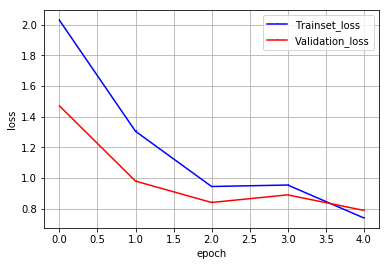

In [24]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_vloss))
plt.plot(x_len, y_loss, marker=',', c='blue', label='Trainset_loss')
plt.plot(x_len, y_vloss, marker=',', c='red', label='Validation_loss')


plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
import math

def plot_history(history):
    
    fig = plt.figure(figsize=(16,10))
       
    n_history_loss = len(history.history)
    n_epochs = len(history.epoch)
    epoch = history.epoch
    
    # The loss is in pairs, one for train, one for val
    loss_stats = [ k for k in history.history.keys() if 'val_' not in k ]
    
    n_cols = 4
    n_rows = math.ceil(len(loss_stats) / n_cols) 
    
    for i, k in enumerate(loss_stats):
        val_k = 'val_'+k
        ax = plt.subplot( n_rows, n_cols, i+1)
        ax.plot(epoch, history.history[k], label=k)
        ax.plot(epoch, history.history[val_k], label=val_k)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(str(i)+' - '+k)
        plt.legend(shadow=True, fancybox=True)
    
    fig.tight_layout()
    plt.show()

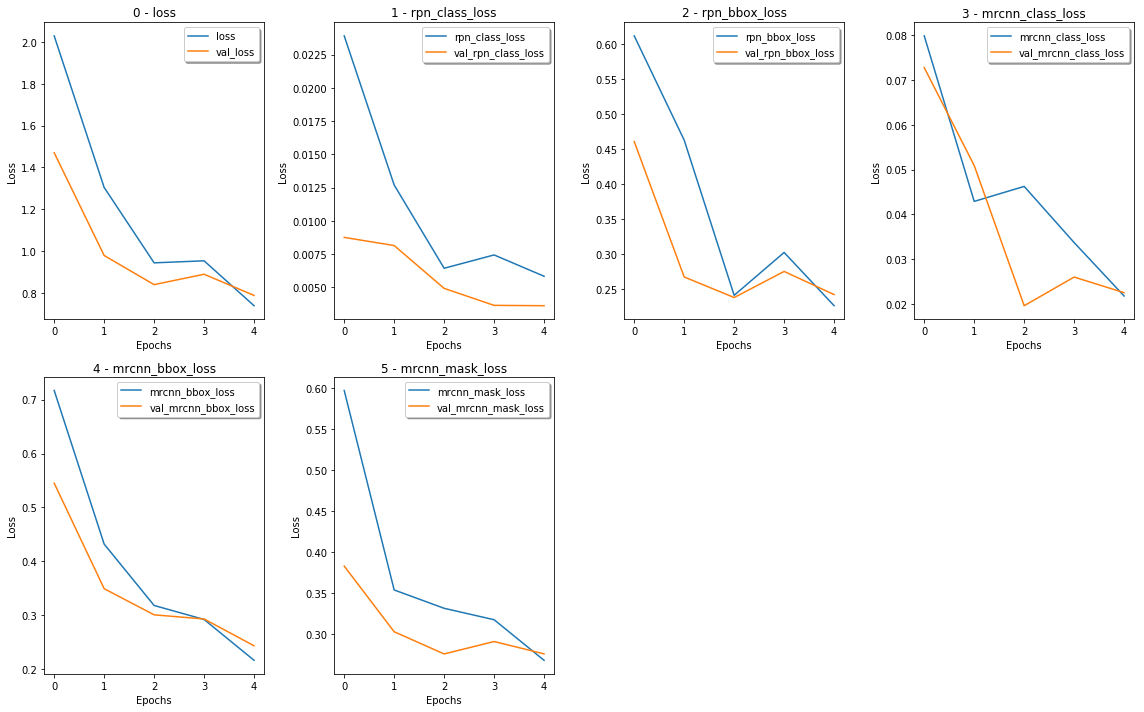

In [26]:
# Plot training stats for each of the networks.
plot_history(history) 

In [0]:
class InferenceConfig(det.DetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#    NUM_CLASSES = 2 # For BG + Others

det.DetConfig.DETECTION_MIN_CONFIDENCE = 0.5
det.DetConfig.ACTIVATION = 'leakyrelu'
inf_config = InferenceConfig('boob', ['alcohol', 'boob', 'cigarette', 'knife' ,'gun', 'mouth', 'hand'])
inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# Find last trained weights
#weights_path = inf_model.find_last()[1]

# When testing use the latest, for demo use stable model
weights_path = os.path.join(models_dir, "alcohol20190814T1558/mask_rcnn_alcohol_0097.h5")
# weights_path = os.path.join(models_dir, "wolf20180516T0136_mask_rcnn_wolf_0075.h5")


print("Using latest weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)

W0815 04:30:59.738803 140511874758528 deprecation_wrapper.py:119] From /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0815 04:30:59.872972 140511874758528 deprecation.py:323] From /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.



Configurations:
ACTIVATION                     leakyrelu
ALL_CLASS_NAMES                ['BG', 'alcohol', 'boob', 'cigarette', 'knife', 'gun', 'mouth', 'hand']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['alcohol', 'boob', 'cigarette', 'knife', 'gun', 'mouth', 'hand']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9

In [0]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [0]:
import math

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])

Processing image /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/images/test/KakaoTalk_20190813_173545255_01.jpg
(854, 569, 3)
Processing 1 images
image                    shape: (854, 569, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  5


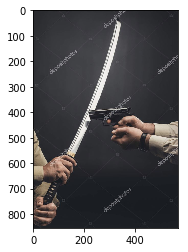

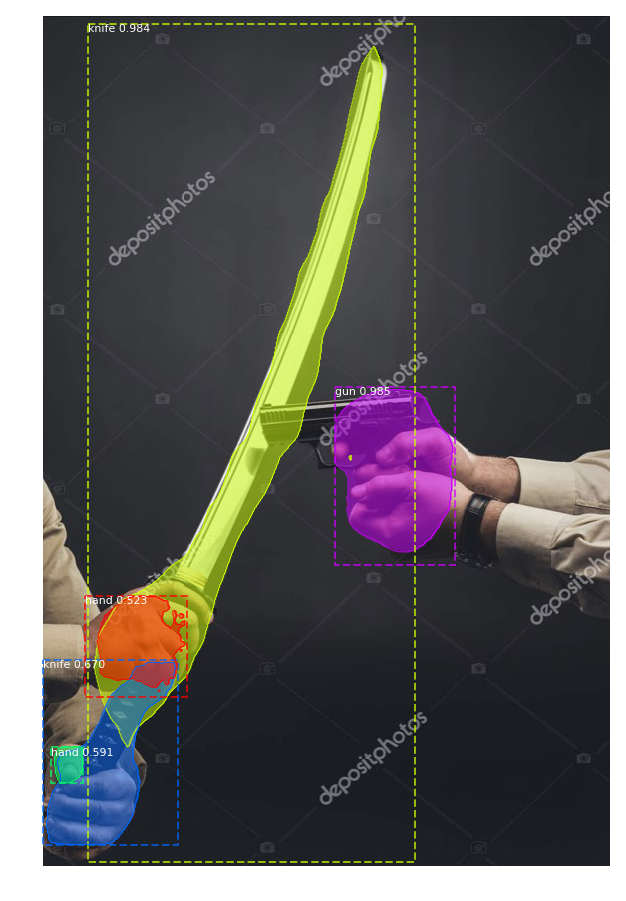

[5 4 4 7 7]
Processing image /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/images/test/KakaoTalk_20190813_173545255_02.jpg
(468, 750, 3)
Processing 1 images
image                    shape: (468, 750, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  4


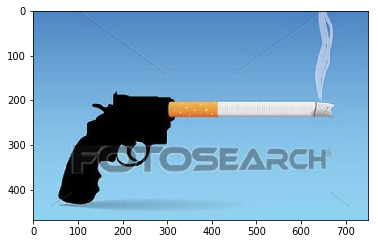

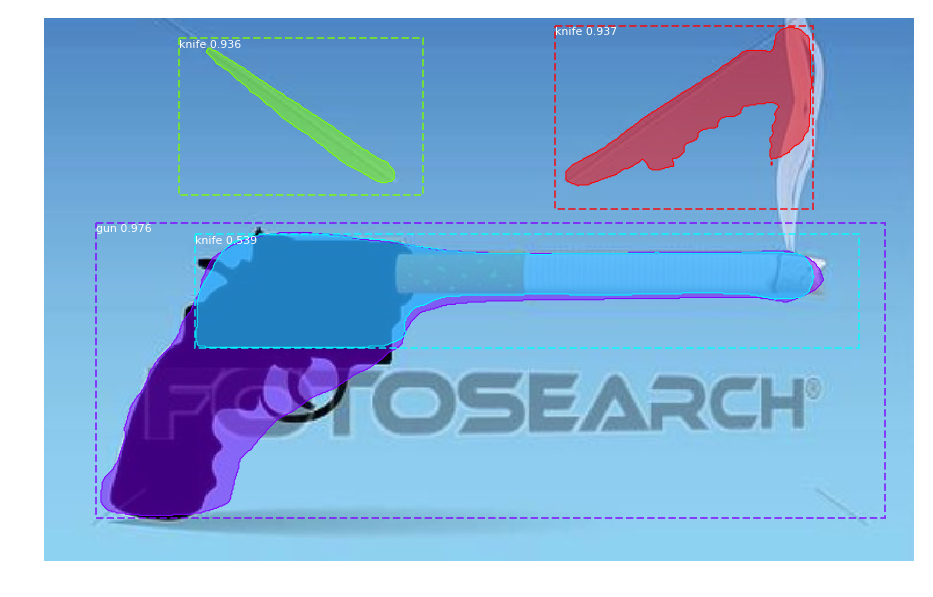

[5 4 4 4]
Processing image /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/images/test/maxresdefault.jpg
(720, 1280, 3)
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  5


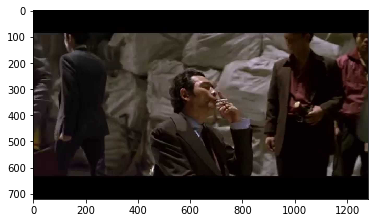

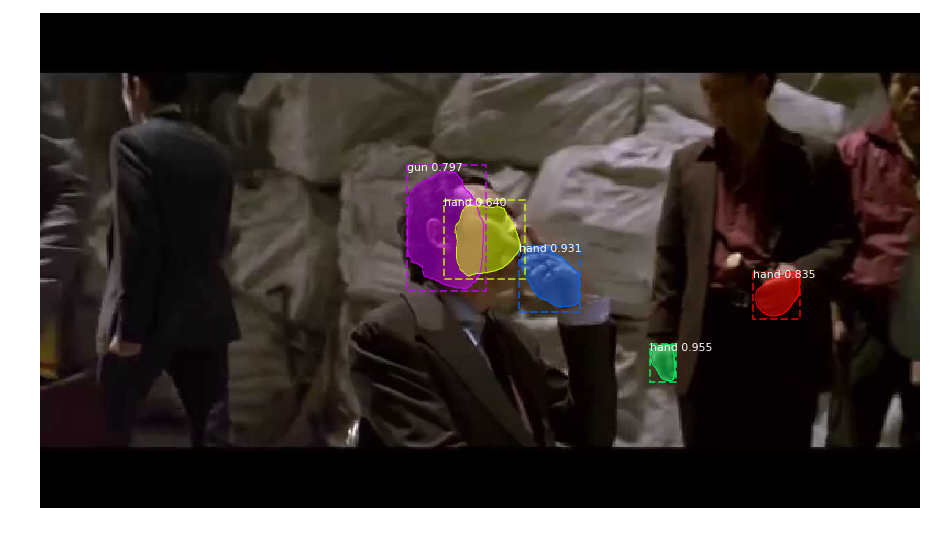

[7 7 7 5 7]
Processing image /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/images/test/스타쉽_트루퍼스_(2).jpg
(365, 596, 3)
Processing 1 images
image                    shape: (365, 596, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  6


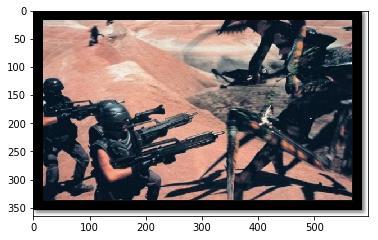

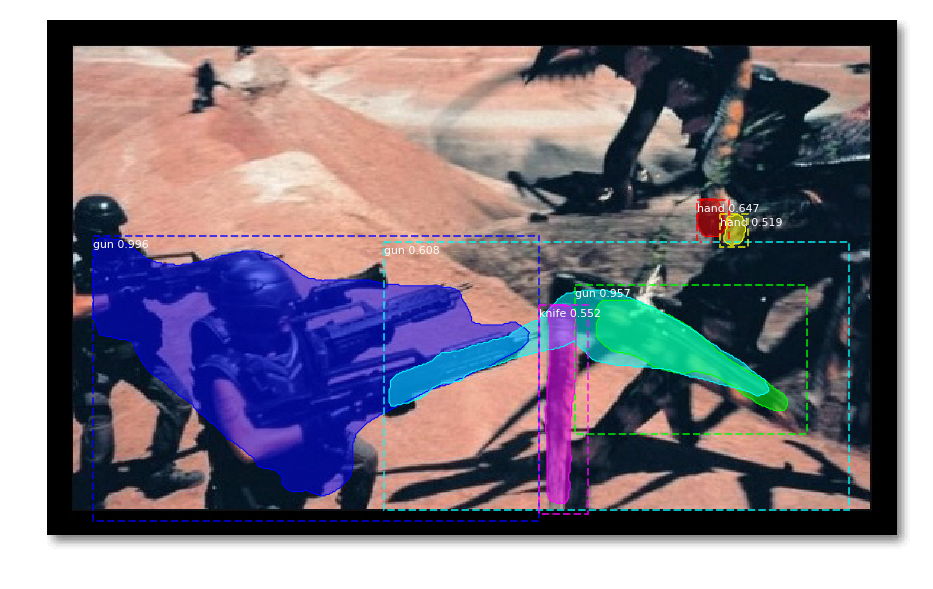

[5 5 7 5 4 7]
Processing image /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/images/test/스타쉽_트루퍼스_(4).jpg
(390, 684, 3)
Processing 1 images
image                    shape: (390, 684, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  2


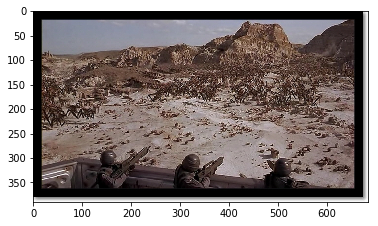

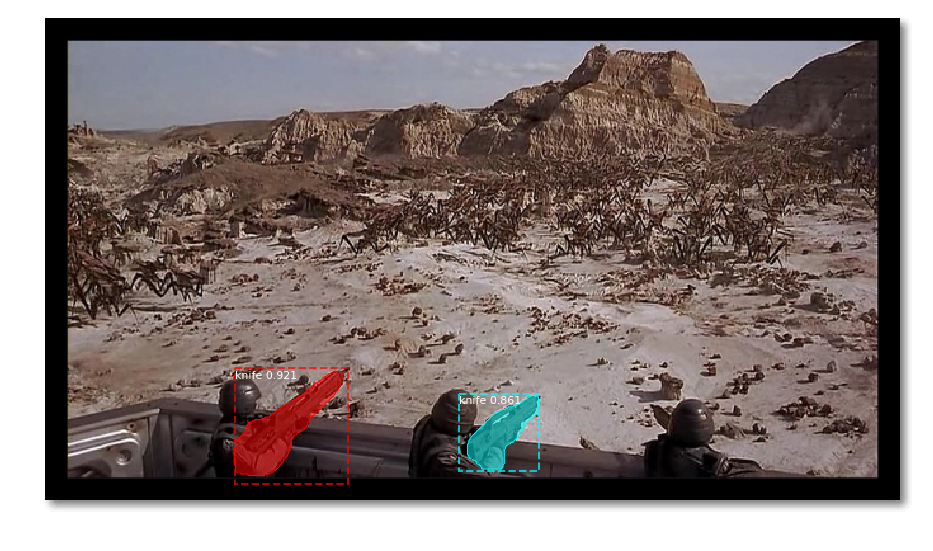

[4 4]
Processing image /content/gdrive/My Drive/Colab Notebooks/BCI/99 project/Mask_RCNN/images/test/스타쉽_트루퍼스_(5).jpg
(392, 684, 3)
Processing 1 images
image                    shape: (392, 684, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  3


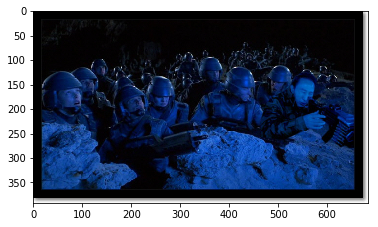

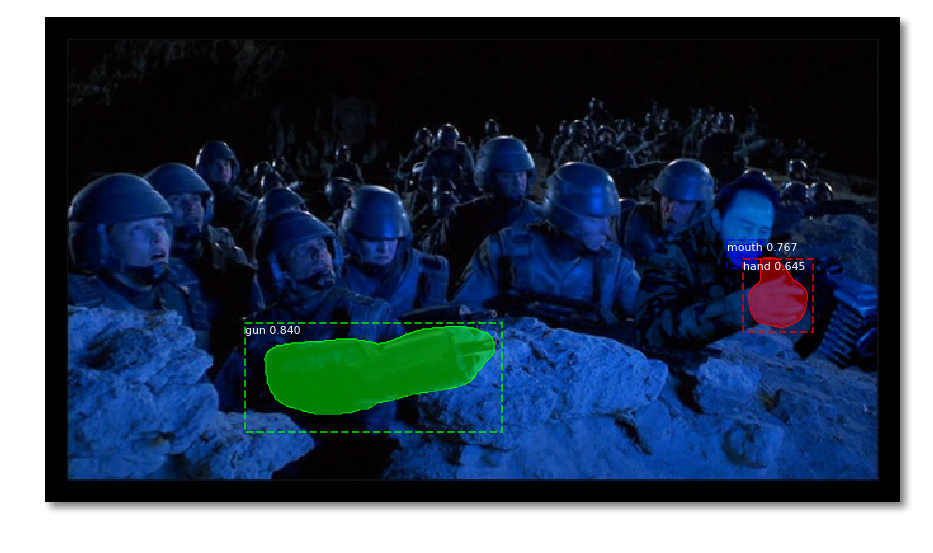

[5 6 7]


In [0]:
image_test_dir = os.path.join(ROOT_IMAGE_DIR, "test/")

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)

In [0]:
_, dataset_val = det.create_datasets(dataset_path + 'all_data2/', inf_config)
dataset_val.prepare()

Counter({'alcohol': 1468, 'hand': 1265, 'gun': 1051, 'mouth': 951, 'knife': 850, 'cigarette': 772, 'boob': 664})
Counter({'alcohol': 362, 'hand': 303, 'gun': 259, 'mouth': 234, 'knife': 210, 'cigarette': 191, 'boob': 167})
Adding class   1:alcohol
Adding class   2:boob
Adding class   3:cigarette
Adding class   4:knife
Adding class   5:gun
Adding class   6:mouth
Adding class   7:hand


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 9175040 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2883584 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to rea

Adding class   1:alcohol
Adding class   2:boob
Adding class   3:cigarette
Adding class   4:knife
Adding class   5:gun
Adding class   6:mouth
Adding class   7:hand


In [0]:
# Compute VOC-Style mAP @ IoU=0.5

# Run on a subset.
#n_image_ids = max(20, len(dataset_val.image_ids))
#image_ids = np.random.choice(dataset_val.image_ids, n_image_ids)
image_ids = dataset_val.image_ids
APs = []

In [0]:
%%time
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inf_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inf_config), 0)
    # Run object detection
    results = inf_model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    print(image_id, AP)
    APs.append(AP)
    
print("mAP: {:.4f}".format(np.mean(APs)))

0 0.5
1 1.0
2 0.1
3 1.0
4 1.0
5 1.0
6 1.0
7 0.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 0.0
19 1.0
20 1.0
21 1.0
22 1.0
23 0.3333333333333333
24 1.0
25 1.0
26 1.0
27 0.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 0.3333333333333333
34 0.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 0.0
41 0.0
42 1.0
43 1.0
44 1.0
45 0.0
46 0.5
47 1.0
48 1.0
49 1.0
50 1.0
51 0.0
52 1.0
53 1.0
54 1.0
55 1.0
56 0.0
57 1.0
58 0.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 1.0
66 1.0
67 1.0
68 0.0
69 1.0
70 1.0
71 1.0
72 1.0
73 0.5
74 1.0
75 0.5
76 1.0
77 1.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 0.0
86 1.0
87 1.0
88 1.0
89 0.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
97 1.0
98 0.0
99 1.0
100 1.0
101 0.5
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 1.0
109 1.0
110 0.5
111 1.0
112 0.5
113 1.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 0.5
121 1.0
122 0.0
123 0.0
124 1.0
125 1.0
126 1.0
127 1.0
128 0.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0


In [0]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inf_config, 700, use_mini_mask=False)

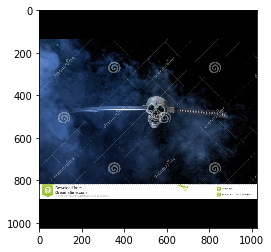

In [0]:
plt.imshow(image)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  4


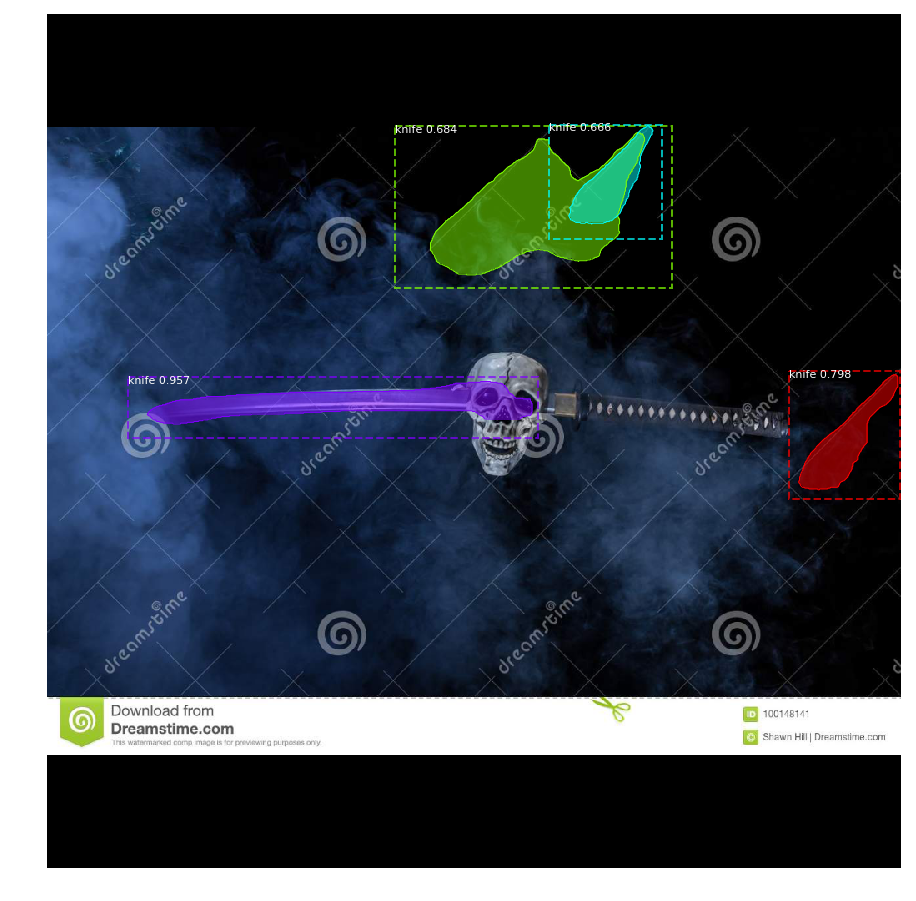

[4 4 4 4]


In [0]:
# Included in the results from detect are the found:
# class_ids,their scores and masks.
results = inf_model.detect([image], verbose=1)[0]

print("Objects detected: ", len(results['class_ids']))

# Visualize results
visualize.display_instances(image, 
                            results['rois'], 
                            results['masks'], 
                            results['class_ids'], 
                            inf_config.ALL_CLASS_NAMES, 
                            results['scores'])
print(results['class_ids'])